In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
daily_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\omega\\"


# Functions: data loading and selection, calculations

Methods of selection:
* data between 2010 and the last available timestamp (2024)
* only top 15% in terms of data abundance
* outliers removed: 0.5% (top and bottom)
* NAs filled forward

In [61]:
def load_data():
    dataframes = []
    for filename in os.listdir(daily_omega):
        path = os.path.join(daily_omega, filename)
        name = filename.replace('.prn', '')
        if 'WIG' in name:
            continue
        df = pd.read_csv(path, delimiter=',', header=0, parse_dates=['Date'], usecols=['Date', 'Close'])
        df.set_index('Date', inplace=True)
        df.rename(columns={"Close": name}, inplace=True)

        dataframes.append(df)
    return dataframes

def concat_dfs_by_date(dataframes, len_quantile = 0.85, statr_year = 2010):
    df_concat = pd.concat(dataframes, axis=1)
    df_concat.index = df_concat.index.astype(dataframes[0].index.dtype)
    
    # only stocks withing the desired time period
    df_concat = df_concat[statr_year:] #from start_year
    df_concat = df_concat.loc[:, (df_concat.iloc[-1].notna() | df_concat.iloc[-2].notna())] #to present

    # only stocks with many time points
    q = df_concat.count().quantile(len_quantile).astype(int)
    df_concat = df_concat.loc[:, df_concat.count() >= q]

    # remove outliers
    qhigh = df_concat.quantile(0.995)
    qlow = df_concat.quantile(0.005)
    df_concat[df_concat > qhigh] = np.nan
    df_concat[df_concat < qlow] = np.nan

    # fill any missing values with last known value
    df_concat.ffill(inplace=True)

    # calculate daily returns
    df_concat = df_concat.pct_change(fill_method=None) # confirmed that this should not be diff
    df_concat = (df_concat - df_concat.mean()) /df_concat.std() # normalization
    return df_concat

def LI(df, tau_list):  # influence shifted forward by tau! 
    LI_tau = []

    I = df.mean(axis=1)
    I2 = I**2

    for tau in tau_list:        

        I2_mean = I2.mean() # I2_mean = I2.shift(periods=-tau).mean()

        corr_mean = (I.shift(periods=tau) * I2).mean()

        LI_tau.append(corr_mean/I2_mean)
    return pd.Series(LI_tau, index=tau_list, name='LI_tau')

def Lsigma(df, tau_list):
    Lsigma_tau = []

    I = df.mean(axis=1)
    I2 = I**2

    for tau in tau_list:        

        I2_mean = I2.mean() # I2_mean = I2.shift(periods=-tau).mean()

        corr_mean = (I.shift(periods=tau) * (df**2).mean(axis=1)).mean()

        Lsigma_tau.append(corr_mean/I2_mean)
    return pd.Series(Lsigma_tau, index=tau_list, name='Lsigma_tau')

def rho(df):
    N = df.shape[1]
    I = df.mean(axis=1)  
    sigma2 = (df**2).mean(axis=1)  

    numerator = (I**2 * N**2) - (N * sigma2)
    denominator = N * (N - 1) * sigma2

    rho_t = numerator / denominator
    return rho_t


def Lrho(df, tau_list):
    Lrho_tau = []

    I = (df).mean(axis=1)
    I2 = I**2

    rho_vals = rho(df)

    for tau in tau_list:    
        
        I2_mean = I2.mean() # I2_mean = I2.shift(periods=-tau).mean()

        corr_mean = (I.shift(periods=tau) * rho_vals).mean()

        Lrho_tau.append(corr_mean/I2_mean)
    return pd.Series(Lrho_tau, index=tau_list, name='Lrho_tau')

In [62]:
dataframes = load_data()
df_concat = concat_dfs_by_date(dataframes)

In [63]:
df_concat.shape

(3894, 61)

# Results

In [65]:
df_concat.columns

Index(['ABPL', 'ACTION', 'AGORA', 'AMBRA', 'AMICA', 'AMREST', 'APATOR',
       'ASBIS', 'ASSECOBS', 'ASSECOPOL', 'ASTARTA', 'ATMGRUPA', 'BETACOM',
       'BIOTON', 'BORYSZEW', 'BUDIMEX', 'BUMECH', 'CCC', 'CEZ', 'COGNOR',
       'COMARCH', 'CORMAY', 'CYFRPLSAT', 'DEBICA', 'DECORA', 'DGA', 'DOMDEV',
       'ECHO', 'ELEKTROTI', 'ENEA', 'ENERGOINS', 'ERBUD', 'EUROCASH',
       'EUROTEL', 'FERRUM', 'FORTE', 'GETIN', 'GTC', 'PEKAO', 'PKNORLEN',
       'PKOBP', 'POLICE', 'POLIMEXMS', 'PROCHEM', 'PULAWY', 'QUERCUS',
       'RAFAKO', 'RAINBOW', 'REDAN', 'RELPOL', 'ROPCZYCE', 'SANOK', 'SFINKS',
       'STALEXP', 'STALPROD', 'SYGNITY', 'TRAKCJA', 'UNIBEP', 'WASKO', 'WAWEL',
       'WIELTON'],
      dtype='object')

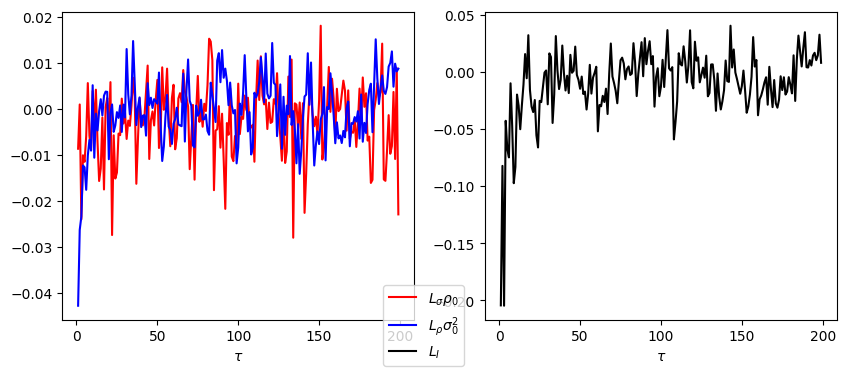

In [64]:
tau_list = np.arange(1, 200, 1)
rho_0 = rho(df_concat).mean()
sigma2_0 = (df_concat**2).mean(axis=1).mean()
LI_vals = LI(df_concat, tau_list)
Lsigma_vals = Lsigma(df_concat, tau_list)
Lrho_vals = Lrho(df_concat, tau_list)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
LI_vals.plot(ax=ax[1], label=r'$L_I$', color='black')
(Lsigma_vals*rho_0).plot(ax=ax[0], label=r'$L_{\sigma}\rho_0$', color='red')
(Lrho_vals*sigma2_0).plot(ax=ax[0], label=r'$L_{\rho}\sigma_0^2$', color='blue')
ax[0].set_xlabel(r'$\tau$')
ax[1].set_xlabel(r'$\tau$')
fig.legend(loc='lower center')

In [59]:
rho_0*sigma2_0

np.float64(0.06118417666797279)

In [60]:
(((df_concat).mean(axis=1))**2).mean()

np.float64(0.10707774401993977)

# Choice of truncation level - 85th quantile

Stock record must be in top 15% in terms of number of data points

This leaves 61 companies and 3894 timestamps

Introduced NA number is of order 100 or less for all companies

In [ ]:
def concat_dfs_by_date(dataframes, len_quantile = 0.5, statr_year = 2010):
    df_concat = pd.concat(dataframes, axis=1)
    df_concat.index = df_concat.index.astype(dataframes[0].index.dtype)
    
    df_concat = df_concat[statr_year:]
    df_concat = df_concat.loc[:, (df_concat.iloc[-1].notna() | df_concat.iloc[-2].notna())] #to present


    #only stocks with many time points
    q = df_concat.count().quantile(len_quantile).astype(int)
    df_concat = df_concat.loc[:, df_concat.count() >= q]

    return df_concat


Text(0, 0.5, 'Maximal fraction of NAs')

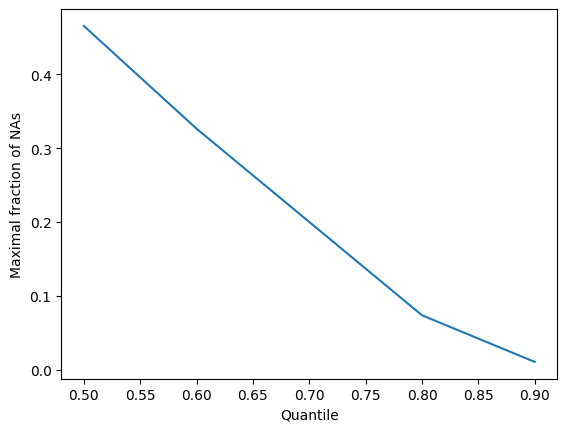

In [53]:
qs = np.arange(0.5, 1, 0.1)

res = [concat_dfs_by_date(dataframes, q).isna().sum().max()/len(concat_dfs_by_date(dataframes, q)) for q in qs]

plt.plot(qs, res)
plt.xlabel('Quantile')
plt.ylabel('Maximal fraction of NAs')

Text(0, 0.5, 'Number of stocks left')

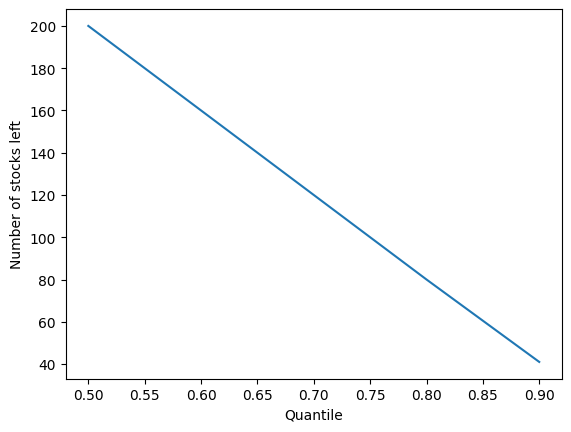

In [52]:
qs = np.arange(0.5, 1, 0.1)

res = [concat_dfs_by_date(dataframes, q).shape[1] for q in qs]

plt.plot(qs, res)
plt.xlabel('Quantile')
plt.ylabel('Number of stocks left')

In [54]:
concat_dfs_by_date(dataframes, 0.85).shape

(3894, 61)